In [1]:
import sys
sys.path.append('/home/emastr/phd/')

from boundary_solvers.gauss_grid_2d import *
from boundary_solvers.geometry import *
import numpy as np
import matplotlib.pyplot as plt
from util.plot_tools import *
from boundary_solvers.blobs import *

### Define Domain

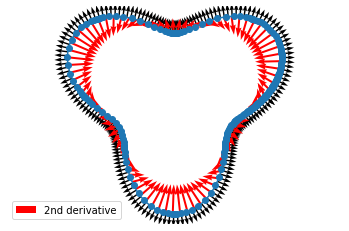

In [10]:
choice = 4 # 1: circle, 2: triangle, 3: rounded square param(t) = exp(1i t)/||exp(1i t)||_P , P > 2.
func = lambda t: np.ones(t.shape, dtype=np.complex128)
    
if choice==1:
    # Boundary parameterisation, circle
    param = lambda t: np.exp(1j * t)
    dparam = lambda t: np.exp(1j * t) * (1j)
    ddparam = lambda t: np.exp(1j * t) * (1j) ** 2
    #params = [param, dparam, ddparam]
    segments = np.array([0,2*np.pi])
    corners = np.zeros_like(segments).astype(int)

elif choice==2:
    # Triangle
    ones = lambda t: np.ones(t.shape, dtype=np.complex128)
    param1 = lambda t: (t-0.5)*2.
    dparam1 = lambda t: ones(t)*2.
    ddparam1 = lambda t: ones(t)*0

    param2 = lambda t: (2. - t) + 1j * (t - 1.)
    dparam2 = lambda t: ones(t) * (-1 + 1j)
    ddparam2 = lambda t: ones(t) * 0

    param3 = lambda t: (2. - t) + 1j * (3. - t)
    dparam3 = lambda t: ones(t)*(-1 - 1j)
    ddparam3 = lambda t: ones(t)*0

    domains = np.array([0.,1.,2.,3.])
    param = Geometry.stitch_functions([param1,param2,param3], domains)
    dparam = Geometry.stitch_functions([dparam1,dparam2,dparam3], domains)
    ddparam = Geometry.stitch_functions([ddparam1,ddparam2,ddparam3], domains)
    #params = [param, dparam, ddparam]
    segments = domains
    corners = np.ones_like(segments).astype(int)
    
elif choice==3:
# rounded Square 
    p = 10#4.5
    norm = lambda t: (np.abs(np.cos(t))**p + np.abs(np.sin(t))**p)**(1/p)
    dnorm = lambda t: norm(t)**(1-p) * np.sin(t)*np.cos(t)*(np.abs(np.sin(t))**(p-2) - np.abs(np.cos(t))**(p-2))
    def ddnorm(t):
        cost = np.cos(t)
        sint = np.sin(t)
        acost = np.abs(cost)
        asint = np.abs(sint)

        normt = norm(t)
        dnormt = dnorm(t)

        rest = (asint ** (p-2) - acost ** (p-2))
        drest = (cost**2-sint**2)*rest + \
                (sint*cost)**2 *(p-2)* (acost**(p-4) + asint**(p-4))


        return dnormt * (1-p) * normt ** (-p) * rest*sint*cost + \
                        normt ** (1-p) * drest    

    param = lambda t: np.exp(1j* t) / norm(t)
    dparam = lambda t: np.exp(1j*t)*(1j/norm(t) - dnorm(t)/norm(t)**2)
    ddparam = lambda t: 1j * dparam(t) + np.exp(1j*t)*(-1j/norm(t)**2*dnorm(t) - ddnorm(t)/norm(t)**2 + 2*dnorm(t)**2/norm(t)**3)
    #params=[param, dparam, ddparam]
    segments = np.array([0, 2*np.pi])
    corners = np.zeros_like(segments).astype(int)

elif choice == 4:
    k = 3
    s = 0.3
    param = lambda t: np.exp(1j * t) * (1 + s * np.sin(k * t))
    dparam = lambda t: np.exp(1j * t) * (1j*(1 + s * np.sin(k * t)) + k*s*np.cos(k * t))
    ddparam = lambda t: np.exp(1j * t) * (-(1 + s * np.sin(k * t)) + 2j * k*s * np.cos(k * t) -k**2 * s*np.sin(k * t))
    #params = [param, dparam, ddparam]
    segments = np.array([0, 2*np.pi])
    corners = np.zeros_like(segments).astype(int)
    
elif choice == 5:
    r = 0.5
    param  = lambda t:  np.cos(t) + r * np.sin(t) * 1j
    dparam = lambda t: -np.sin(t) + r * np.cos(t) * 1j
    ddparam = lambda t: -np.cos(t) - r * np.sin(t) * 1j
    #params = [param, dparam, ddparam]
    segments = np.array([0, 2*np.pi])
    corners = np.zeros_like(segments).astype(int)

elif choice == 6:
    r, dr, ddr = Geometry.get_line_2d(-1-1j,  1-1j, 0.0 * np.pi, 0.5 * np.pi)
    u, du, ddu = Geometry.get_line_2d( 1-1j,  1+1j, 0.5 * np.pi, 1.0 * np.pi)
    l, dl, ddl = Geometry.get_line_2d( 1+1j, -1+1j, 1.0 * np.pi, 1.5 * np.pi)
    b, db, ddb = Geometry.get_line_2d(-1+1j, -1-1j, 1.5 * np.pi, 2.0 * np.pi)

    segments = np.linspace(0,2*np.pi,5)
    corners = np.ones_like(segments).astype(int)

    param1 = Geometry.stitch_functions_1d([r,u,l,b], segments)
    dparam1 = Geometry.stitch_functions_1d([dr,du,dl,db], segments)
    ddparam1 = Geometry.stitch_functions_1d([ddr,ddu,ddl,ddb], segments)
    
    param = lambda t: np.exp(1j * np.pi / 5) * param1(t)
    dparam = lambda t: np.exp(1j * np.pi / 5) * dparam1(t)
    ddparam = lambda t: np.exp(1j * np.pi / 5) * ddparam1(t)
    
    
params = [param, dparam, ddparam]

    
grid = GaussLegGrid(segments=segments, corners=None)
grid.refine_all_nply(3)
grid.refine_corners_nply(3)
geom = Geometry(param=params,grid=grid)
geom.plot(ax=plt.gca(), showpts=True, shownormals=True)

if True:
    t = np.linspace(0,2*np.pi, 100)
    z = param(t)
    x,y = np.real(z), np.imag(z)
    ddz = ddparam(t)
    ddx, ddy = np.real(ddz), np.imag(ddz)
    plt.quiver(x,y,ddx,ddy, color='red', label="2nd derivative")
    

plt.axis("equal")
remove_axes(plt.gca())
plt.legend()

## Precomputing line averages in the interior
Next, we investigate the solution of the adjoint system, where the arguments in the kernel are switched. For example, if

\begin{equation}
    (\mathcal{K}v)(t) = \int_\Gamma \kappa(t,s)v(s)\mathrm{d}s,
\end{equation}

then the adjoint is obtained as

\begin{equation}
    (\mathcal{K}^* v)(t) = \int_\Gamma \kappa(s,t)v(s)\mathrm{d}s.
\end{equation}

Solving with respect to the adjoint is implemented as a part of the geometry. We use it to obtain mean velocity measurements across lines in the interior domain.

### Cauchy Condition (Riesz Vector Maximises Net Tangental Flow)

In [11]:
K = geom.stokes_matrix()
Kt = geom.stokes_adjoint_matrix()
v = lambda t: np.conjugate(geom.eval_param(t=t))

t,_ = grid.get_grid_and_weights()
n = len(t)

vt  = v(t)[:, None]
real_repr = lambda v: np.vstack([np.real(v), np.imag(v)])
imag_repr = lambda v: v[:n] + 1j * v[n:]


print(geom.inner(vt.T, imag_repr(K @ real_repr(vt)).T))
print(geom.inner(imag_repr(Kt @ real_repr(vt)).T, vt.T))


[9.34352677]
[9.34352677]


Converged in 0 iterations
Riesz estimate of max average velocity: 0.5707986571490795
Riesz estimate of stirring average velocity: 0.03500000475427231


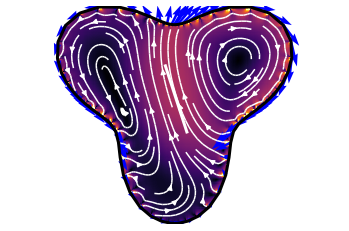

In [4]:
s = 0.3
sol = lambda z: np.conjugate(z)
condition = lambda t: sol(params[0](t))#+ (1+1j)*np.ones(t.shape, dtype=np.complex128)

plt.figure()
grid = GaussLegGrid(segments=[0,2*np.pi], corners=None)
grid.refine_all_nply(2)
geom = Geometry(param=params,grid=grid)
problem = StokesDirichletProblem(condition=condition, geometry=geom)

o =  0.3 #0.55
a =  0.3*np.exp(1j*o*np.pi*2)
b = -0.4*np.exp(1j*o*np.pi*2)

#print("Precompute field")
func, vel_avg = geom.precompute_line_avg(a, b, tol=1e-13, verbose=True, maxiter=40)
param = geom.eval_param()


#func = f1
problem.condition = lambda t: geom.zero_flow(func / geom.inner(func, func)**0.5) #np.linalg.norm(func)
problem.solve(tol=1e-10, maxiter=40)

vel = lambda z: np.abs(problem.evaluate(z))
problem.geometry.plot_field(ax=plt.gca(), func=vel, apply_mask=True, cmap='inferno', vmax=1)
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='white')
plt.axis("equal")

#problem.plot(plt.gca())
plt.plot(np.real(param), np.imag(param), 'black', linewidth=3)
plt.quiver(np.real(param), np.imag(param), np.real(func), np.imag(func), color='blue')
plt.plot([np.real(a), np.real(b)],[np.imag(a), np.imag(b)], color="white", linewidth=3)
plt.axis("equal")
remove_axes(plt.gca())
print(f"Riesz estimate of max average velocity: {vel_avg(func)}")
print(f"Riesz estimate of stirring average velocity: {vel_avg(param)}")

### Net Flow Test

For the field $u(z) = \overline{z}$, the net tangental flow across a line from $a \in \mathbb{C}$ to $b\in\mathbb{C}$ is exactly $\Re\left(\frac{b^2-a^2}{2}\right)$. We investigate if this formula holds.

Analytic: 0.020225424859373693. Numerical: 0.020226131421148208
Analytic deriv: -0.29389262614623657. Numerical: -0.29389717213372224
Analytic deriv: -0.29389262614623657. Numerical: -0.30504033274887776
Diff: 7.065617745154185e-07


(-1.0, 1.0)

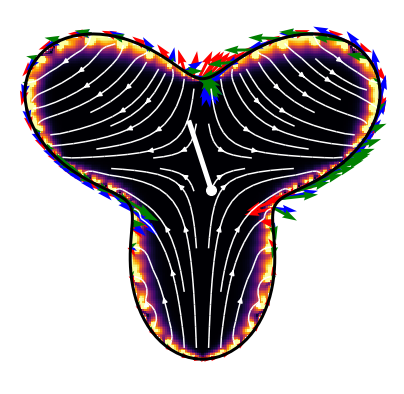

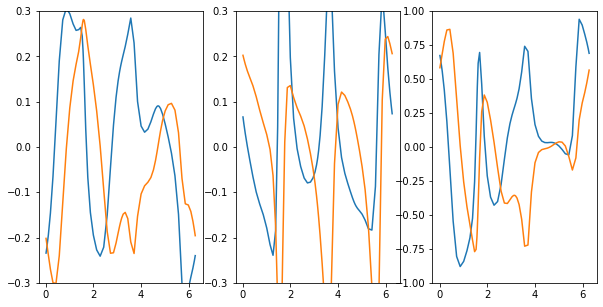

In [5]:
s = 0.4
sol = lambda z: np.conjugate(z)
condition = lambda t: sol(params[0](t))#+ (1+1j)*np.ones(t.shape, dtype=np.complex128)

a = 0.3 * np.exp(1j * 2 * np.pi * 0.3)
b = 0.2 * np.exp(1j * 2 * np.pi * (-0.2))

# Define grid, geometry and problem objects
grid = GaussLegGrid(segments=segments, corners=corners)
grid.refine_all_nply(2)
grid.refine_corners_nply(3)
geom = Geometry(param=params,grid=grid)

# Problem 1: u(z) = conj(z)
problem = StokesDirichletProblem(condition=condition, geometry=geom)
problem.solve(tol=1e-4)
riesz_vec, func = geom.precompute_line_avg(a, b, tol=1e-10, maxiter=200)
riesz_vec2, func2 = geom.precompute_line_avg(a, b, derivative=1, tol=1e-10, maxiter=200)
riesz_vec3, func3 = geom.line_eval_adjoint(a, b, derivative=1, tol=1e-10, maxiter=200)

t,_ = grid.get_grid_and_weights()
z = geom.eval_param()
cond_vec = problem.condition(t)


print(f"Analytic: {np.real((b**2 - a**2)/2)}. Numerical: {func(condition(t))}")
print(f"Analytic deriv: {np.imag((b-a)**2)/np.abs(b-a)}. Numerical: {func2(condition(t))}")
print(f"Analytic deriv: {np.imag((b-a)**2)/np.abs(b-a)}. Numerical: {func3(condition(t))}")
print(f"Diff: {np.abs(np.real((b**2 - a**2)/2) - func(condition(t)))}")

# Plot
plt.figure(figsize=(7,7))
problem.geometry.plot_field(ax=plt.gca(), func=lambda z: np.abs(problem.evaluate(z)-sol(z).T), \
                            apply_mask=True, cmap='inferno', vmax=1)
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='white')
problem.geometry.plot(ax=plt.gca(), color="black", linewidth=3)
plt.quiver(np.real(z), np.imag(z), np.real(riesz_vec), np.imag(riesz_vec),scale=4, color="red")
plt.quiver(np.real(z), np.imag(z), np.real(riesz_vec2), np.imag(riesz_vec2),scale=10, color="blue")
plt.quiver(np.real(z), np.imag(z), np.real(riesz_vec2), np.imag(riesz_vec3),scale=10, color="green")
plt.plot([np.real(a), np.real(b)], [np.imag(a), np.imag(b)], '-', color='white', linewidth=5)
plt.scatter(np.real(b), np.imag(b), marker="o", s=100, c="white")
plt.axis("equal")
remove_axes(plt.gca())

# Problem 2: u(z) = maximise tangental flow
#problem2 = StokesDirichletProblem(condition=lambda t: riesz_vec, geometry=geom)
#problem2.solve(tol=1e-6)

#plt.subplot(1,2,2)
#problem2.geometry.plot_field(ax=plt.gca(), func=lambda z: np.abs(problem2.evaluate(z)), \
#                            apply_mask=True, cmap='inferno', vmax=2)
#problem2.geometry.plot_stream(ax=plt.gca(), func=problem2.evaluate, apply_mask=True, color='white')
#problem2.geometry.plot(ax=plt.gca(), color="black", linewidth=3)
#plt.plot([np.real(a), np.real(b)], [np.imag(a), np.imag(b)], '-', color='white', linewidth=5)
#plt.axis("equal")
#remove_axes(plt.gca())

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.plot(t, np.real(riesz_vec))
plt.plot(t, np.imag(riesz_vec))
plt.ylim([-0.3,0.3])

plt.subplot(1,3,2)
plt.plot(t, np.real(riesz_vec3))
plt.plot(t, np.imag(riesz_vec3))
plt.ylim([-0.3,0.3])

plt.subplot(1,3,3)
plt.plot(t, np.real(riesz_vec2))
plt.plot(t, np.imag(riesz_vec2))
plt.ylim([-1,1])




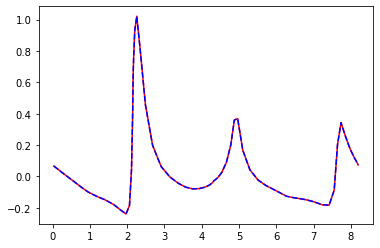

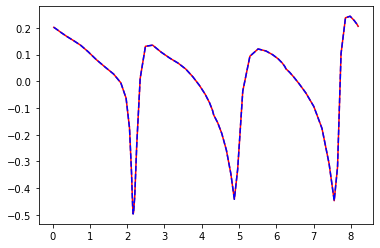

In [6]:
# Testa så att line_eval_adjoint funkar

## print(f"{a}, {b}")
log = lambda z: np.log(np.abs(z)) + 1j * np.angle(z)

# Conjugate operator
c = lambda z: np.conjugate(z)
im = lambda z: np.imag(z)

# Tangent vector
da = b-a      
e = da / 1j / np.abs(da) 

g = geom.eval_param()
dg = geom.eval_param(derivative=1)
ga = g - a
gb = g - b
log_ba = log(gb / ga) / da
ga_gb = ga * gb
#riesz_vec4 = (da * np.imag(- dg * log(dgb / dga) / da) \
#            + np.imag(dac * dg) * log(np.conjugate(dgb / dga)) / dac \
#            + np.imag(dga * dac) * dgc / np.conjugate(dga * dgb))/ np.pi

riesz_vec4 = -(- da * im(dg * e  / ga_gb) 
              - im(c(e) * dg) * c(da / ga_gb) \
              + 2*c(e) *im(dg * c(da)) / c(ga_gb)\
              - im(ga * c(da)) * c(e * dg * (ga + gb) / ga_gb ** 2)) / np.pi / np.abs(dg)

        
t, w = grid.get_grid_and_weights()
dz = geom.eval_param(derivative=1)
arc = np.cumsum(np.abs(dz) * w)
    
plt.plot(arc, np.real(riesz_vec3), 'r')
plt.plot(arc, np.real(riesz_vec4), 'b--')

plt.figure()
plt.plot(arc, np.imag(riesz_vec3), 'r')
plt.plot(arc, np.imag(riesz_vec4), 'b--')

## Operator Spectra


In [7]:
def coimage(A):
    A = np.atleast_2d(A)
    _, _, vh = np.linalg.svd(A)
    ns = vh[:-1].conj().T
    return ns

K = geom.stokes_matrix()
Kt = geom.stokes_adjoint_matrix()

V = coimage(Kt)
U = Kt @ V
B = (V.T @ Kt.T @ Kt @ V)

def solve_adjoint(b):
    return V @ np.linalg.solve(B, U.T @ b)


3269.195359694047
3 smallest eigenvalues: [0.18164409+0.j 0.18164731+0.j 0.3382192 +0.j]
cond. no: 63.28683639352356
3 smallest eigenvalues: [0.18164409+0.j 0.18164769+0.j 0.4299938 +0.j]
cond. no: 57.70171450752247


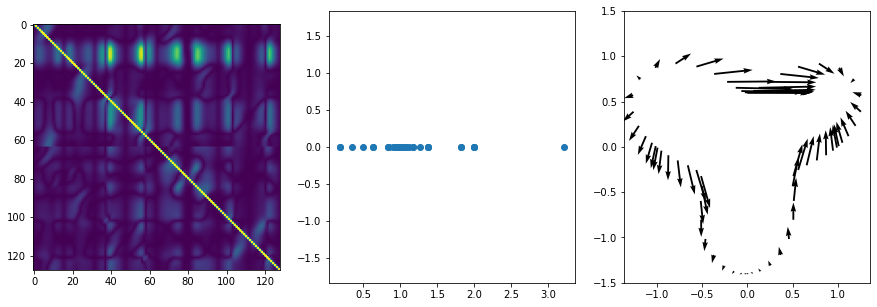

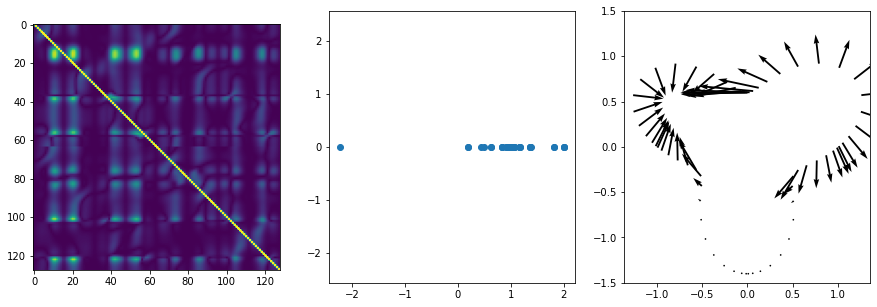

In [8]:
print(np.linalg.cond(B))

z = geom.eval_param()
dz = geom.eval_param(derivative=1)
ddz = geom.eval_param(derivative=2)


n = len(z)

for A in (K, Kt):
    res = np.linalg.eig(A)
    eig = res[0]
    vec = res[1]

    arg = np.argsort(np.abs(eig))
    eig = eig[arg]
    vec = vec[:,arg]

    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(np.abs(A), vmax=.5)

    plt.subplot(1,3,2)
    plt.scatter(np.real(eig), np.imag(eig))
    plt.axis("equal")
    print(f"3 smallest eigenvalues: {eig[:3]}")
    
    plt.subplot(1,3,3)
    #plt.figure(figsize=(10,10))
    #plt.plot(vec[:,0])
    n = len(z)
    plt.quiver(np.real(z), np.imag(z), np.real(vec[n:,0]), -np.real(vec[:n,0]), scale=1)
    #plt.quiver(np.real(z), np.imag(z), np.imag(dz), -np.real(dz), scale=20, color='red')
    #plt.quiver(np.real(z), np.imag(z), np.real(ddz), np.imag(ddz), scale=20, color='blue')
    #plt.quiver(np.real(z), np.imag(z), np.real(c), np.imag(c), scale=1, color='green')
    plt.axis("equal")
    plt.xlim([-1.5,1.5])
    plt.ylim([-1.5,1.5])
    
    print(f"cond. no: {np.linalg.cond(A)}")
    #print(A[:n,:n].sum(axis=1))
    #print(A[n:,:n].sum(axis=1))

## Define Micro Domain With Shape Parameters

In [9]:
# Grid
segments = np.linspace(0,2*np.pi,5)
corners = np.ones_like(segments).astype(int)
grid = GaussLegGrid(segments=segments, corners=corners)
grid.refine_all_nply(1)
grid.refine_corners_nply(1)
t,_ = grid.get_grid_and_weights()

##### GEOMETRY ############
m = 2
L = 1
H = 2
eps = 0.1
dt = 0.2 * np.pi

### Floor
f = lambda t: eps*(-1 + np.cos(4 * m * t + dt))*1j + L * t/(0.5*np.pi)
df = lambda t: eps*(-(4 * m) * np.sin(4 * m * t + dt))*1j + L/(0.5*np.pi)
ddf = lambda t: eps*(-(4 * m)**2 * np.cos(4 * m * t + dt))*1j

### Stitch boundary
segments = np.linspace(0, 2*np.pi, 5)
r, dr, ddr = GaussLegGeometry.get_line_2d(f(.5*np.pi), H*1j+L, 0.5 * np.pi, 1.0 * np.pi)
u, du, ddu = GaussLegGeometry.get_line_2d(H*1j+L     , H*1j  , 1.0 * np.pi, 1.5 * np.pi)
l, dl, ddl = GaussLegGeometry.get_line_2d(H*1j       , f(0)  , 1.5 * np.pi, 2.0 * np.pi)

z = GaussLegGeometry.stitch_functions_1d([f,r,u,l], segments)
dz = GaussLegGeometry.stitch_functions_1d([df,dr,du,dl], segments)
ddz = GaussLegGeometry.stitch_functions_1d([ddf,ddr,ddu,ddl], segments)
geom = GaussLegGeometry([z,dz,ddz], grid=grid)


###### PROBLEM ############
condition = lambda t: np.conjugate(z(t))
problem = StokesDirichletProblem(condition=condition, geometry=geom)


eps2 = 0.1 # To combat rounding error
gamma = 0.4
a = gamma * 1j + eps2
b = gamma * 1j + L - eps2

### Geometry of the line, "H"
eps2 = 0.1 
gamma = 0.5
a = gamma * 1j + eps2
b = gamma * 1j + L - eps2

###### SOLVE ##############
problem.solve(verbose=True, tol = 1e-6, maxiter=40)
riesz_vec, func = geom.precompute_line_avg(a,b,derivative=0,tol=1e-10, maxiter=100)
riesz_vec2, func2 = geom.precompute_line_avg(a,b,derivative=1,tol=1e-10, maxiter=100)

###### PLOT ##############
print(f"Average of tangental component of velocity = {func(condition(t))}, analytic={np.real(b**2 - a**2)/2}")
print(f"Average of tangental component of normal derivative  = {func2(condition(t))}, analytic={np.imag((b-a)**2)/np.abs(b-a)}")
print(f"Shear stress alpha  = {- func(condition(t)) / func2(condition(t))}")

plt.figure(figsize=(15,7))

# Subplot 1
plt.subplot(1,2,1)
problem.geometry.plot_field(ax=plt.gca(), func=lambda z: np.abs(problem.evaluate(z)), \
                            apply_mask=True, cmap='inferno', vmax=4)
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='white')
problem.geometry.plot(ax=plt.gca(), color="black", linewidth=3)
plt.plot([np.real(a), np.real(b)], [np.imag(a), np.imag(b)], '-', color='white', linewidth=3)
plt.axis("equal")
remove_axes(plt.gca())


# Subplot 2
plt.subplot(1,2,2)
geom.plot(ax=plt.gca(), shownormals=True, showpts=True)
plt.quiver(np.real(z(t)), np.imag(z(t)), np.real(riesz_vec), np.imag(riesz_vec), color="red",zorder=2, scale=10)
plt.axis("equal")
remove_axes(plt.gca())


# Plot
plt.figure()
plt.plot(t, np.real(riesz_vec))
plt.plot(t, np.imag(riesz_vec))
plt.plot(t, np.imag(riesz_vec))

NameError: name 'GaussLegGeometry' is not defined

In [22]:
%timeit geom.precompute_line_avg(a, b, derivative=1, tol=1e-13, maxiter=200, verbose=True)
%timeit geom.line_eval_adjoint(a, b, derivative=0, tol=1e-13, maxiter=200)

Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in 0 iterations
Converged in

Let's try more realistic boundary conditions, with zero slip at the floor.

0
Average of tangental component of velocity = 0.38758720888606213
Average of tangental component of normal derivative  = 0.749844231271762
Shear stress alpha  = -0.5168902989740958


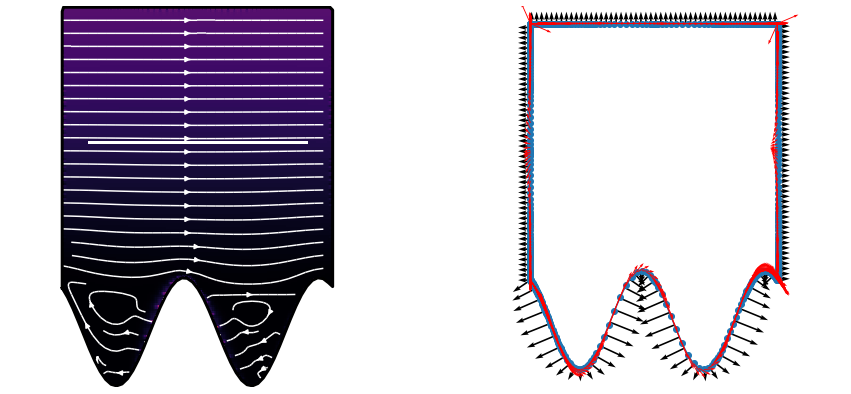

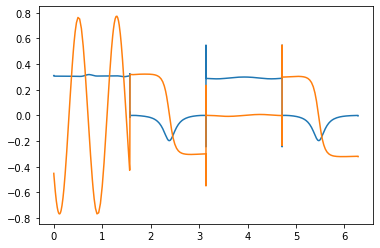

In [23]:
# Grid
segments = np.linspace(0,2*np.pi,5)
corners = np.ones_like(segments).astype(int)
grid = GaussLegGrid(segments=segments, corners=corners)
grid.refine_all_nply(1)
grid.refine_corners_nply(5)
t,_ = grid.get_grid_and_weights()

##### GEOMETRY ############
m = 2
L = 1
eps = 0.2
dt = 0.2 * np.pi
H = 1

### Floor
f = lambda t: eps*(-1 + np.cos(4 * m * t + dt))*1j + L * t/(0.5*np.pi)
df = lambda t: eps*(-(4 * m) * np.sin(4 * m * t + dt))*1j + L/(0.5*np.pi)
ddf = lambda t: eps*(-(4 * m)**2 * np.cos(4 * m * t + dt))*1j

### Stitch boundary
r, dr, ddr = GaussLegGeometry.get_line_2d(f(.5*np.pi), H*1j+L, 0.5 * np.pi, 1.0 * np.pi)
u, du, ddu = GaussLegGeometry.get_line_2d(H*1j+L     , H*1j  , 1.0 * np.pi, 1.5 * np.pi)
l, dl, ddl = GaussLegGeometry.get_line_2d(H*1j       , f(0)  , 1.5 * np.pi, 2.0 * np.pi)

z = GaussLegGeometry.stitch_functions_1d([f,r,u,l], segments)
dz = GaussLegGeometry.stitch_functions_1d([df,dr,du,dl], segments)
ddz = GaussLegGeometry.stitch_functions_1d([ddf,ddr,ddu,ddl], segments)
geom = GaussLegGeometry([z,dz,ddz], grid=grid)


###### PROBLEM ############
condition = lambda t: np.clip(np.imag(z(t)), 0, 1)
problem = StokesDirichletProblem(condition=condition, geometry=geom)

### Geometry of the line, "H"
eps2 = 0.1 
gamma = 0.5
a = gamma * 1j + eps2
b = gamma * 1j + L - eps2

###### SOLVE ##############
problem.solve(verbose=True, tol = 1e-6, maxiter=40)
riesz_vec, func = geom.precompute_line_avg(a,b,derivative=0,tol=1e-10, maxiter=100)
riesz_vec2, func2 = geom.precompute_line_avg(a,b,derivative=1,tol=1e-10, maxiter=100)

###### PLOT ##############
print(f"Average of tangental component of velocity = {func(condition(t))}")
print(f"Average of tangental component of normal derivative  = {func2(condition(t))}")
print(f"Shear stress alpha  = {- func(condition(t)) / func2(condition(t))}")

plt.figure(figsize=(15,7))

# Subplot 1
plt.subplot(1,2,1)
problem.geometry.plot_field(ax=plt.gca(), func=lambda z: np.abs(problem.evaluate(z)), \
                            apply_mask=True, cmap='inferno', vmax=4)
problem.geometry.plot_stream(ax=plt.gca(), func=problem.evaluate, apply_mask=True, color='white')
problem.geometry.plot(ax=plt.gca(), color="black", linewidth=3)
plt.plot([np.real(a), np.real(b)], [np.imag(a), np.imag(b)], '-', color='white', linewidth=3)
plt.axis("equal")
remove_axes(plt.gca())


# Subplot 2
plt.subplot(1,2,2)
geom.plot(ax=plt.gca(), shownormals=True, showpts=True)
plt.quiver(np.real(z(t)), np.imag(z(t)), np.real(riesz_vec), np.imag(riesz_vec), color="red",zorder=2, scale=10)
plt.axis("equal")
remove_axes(plt.gca())


# Plot
plt.figure()
plt.plot(t, np.real(riesz_vec))
plt.plot(t, np.imag(riesz_vec))

In [10]:
print(np.linalg.cond(geom.stokes_adjoint_matrix()))

721.3468723264895
